### Loan Application Status Prediction by Francis Afuwah.
Batch: DS2312

### Overview:
This project is aimed to create a predictive model capable of determining the likelihood of a loan being approved based on applicant-specific data. The dataset provided contained variables such as gender, marital status, education, employment status, various income metrics, credit history, and property location, among others.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
# Load the dataset
loan_data=pd.read_csv("loan_prediction.csv")

### Viewing the dataset

In [3]:
# Display the first few rows of the dataset and basic info
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
 loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
loan_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Handling missing data
1. Resolving Missing Data: For categorical variables such as 'Gender', 'Married', 'Dependents', and 'Self_Employed', missing entries were filled using the most common value in each category. For numerical fields like 'LoanAmount', 'Loan_Amount_Term', and 'Credit_History', missing values were replaced using the median or mode, tailored to the nature of the data distribution.
2. Transforming Categorical Data: Binary attributes ('Education', 'Self_Employed', 'Loan_Status') were transformed using label encoding.Multiclass categorical variables ('Gender', 'Married', 'Property_Area') underwent one-hot encoding to facilitate their inclusion in the model.

In [6]:
# Handling missing values
# Filling categorical columns with the mode
for column in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    loan_data[column].fillna(loan_data[column].mode()[0], inplace=True)

In [7]:
# Filling numerical columns with median or mode
loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].median(), inplace=True)
loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].mode()[0], inplace=True)
loan_data['Credit_History'].fillna(loan_data['Credit_History'].mode()[0], inplace=True)

In [8]:
# Check if all missing values are filled
loan_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Exploratory Data Analysis (EDA)
1. Distribution Observations:'ApplicantIncome' and 'CoapplicantIncome' both displayed right-skewed distributions, highlighting a predominance of lower-income applicants.The 'LoanAmount' distribution was somewhat skewed to the right but showed a closer alignment with a normal distribution, reflecting diverse loan requirements across applicants.
2. Relationship Analysis:There was a noticeable positive correlation between 'Credit_History' and 'Loan_Status', indicating that applicants with positive credit histories tend to have higher approval rates.Income levels were correlated with the loan amount, suggesting that applicants with higher incomes often seek and are granted larger loans.
3. Category-Based Influence on Approval:Applicants with a college degree showed a higher likelihood of approval compared to those without.Non-self-employed individuals were favored for loan approvals, likely due to the perceived stability of their employment.The area of residence (urban vs. non-urban) did not significantly influence loan approval rates, suggesting that location is not a critical factor in the decision-making process.

In [9]:
# Label Encoding for binary categories
label_encoder = LabelEncoder()
loan_data['Education'] = label_encoder.fit_transform(loan_data['Education'])
loan_data['Self_Employed'] = label_encoder.fit_transform(loan_data['Self_Employed'])
loan_data['Loan_Status'] = label_encoder.fit_transform(loan_data['Loan_Status'])

# Handling 'Dependents' (transform '3+' to 3 for simplicity)
loan_data['Dependents'] = loan_data['Dependents'].replace('3+', 3).astype(int)

In [10]:
# One-Hot Encoding for other categorical variables
loan_data = pd.get_dummies(loan_data, columns=['Gender', 'Married', 'Property_Area'], drop_first=True)

In [11]:
# Display the modified dataset with encoded values
loan_data.head()

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0,0,0,5849,0.0,128.0,360.0,1.0,1,True,False,False,True
1,LP001003,1,0,0,4583,1508.0,128.0,360.0,1.0,0,True,True,False,False
2,LP001005,0,0,1,3000,0.0,66.0,360.0,1.0,1,True,True,False,True
3,LP001006,0,1,0,2583,2358.0,120.0,360.0,1.0,1,True,True,False,True
4,LP001008,0,0,0,6000,0.0,141.0,360.0,1.0,1,True,False,False,True


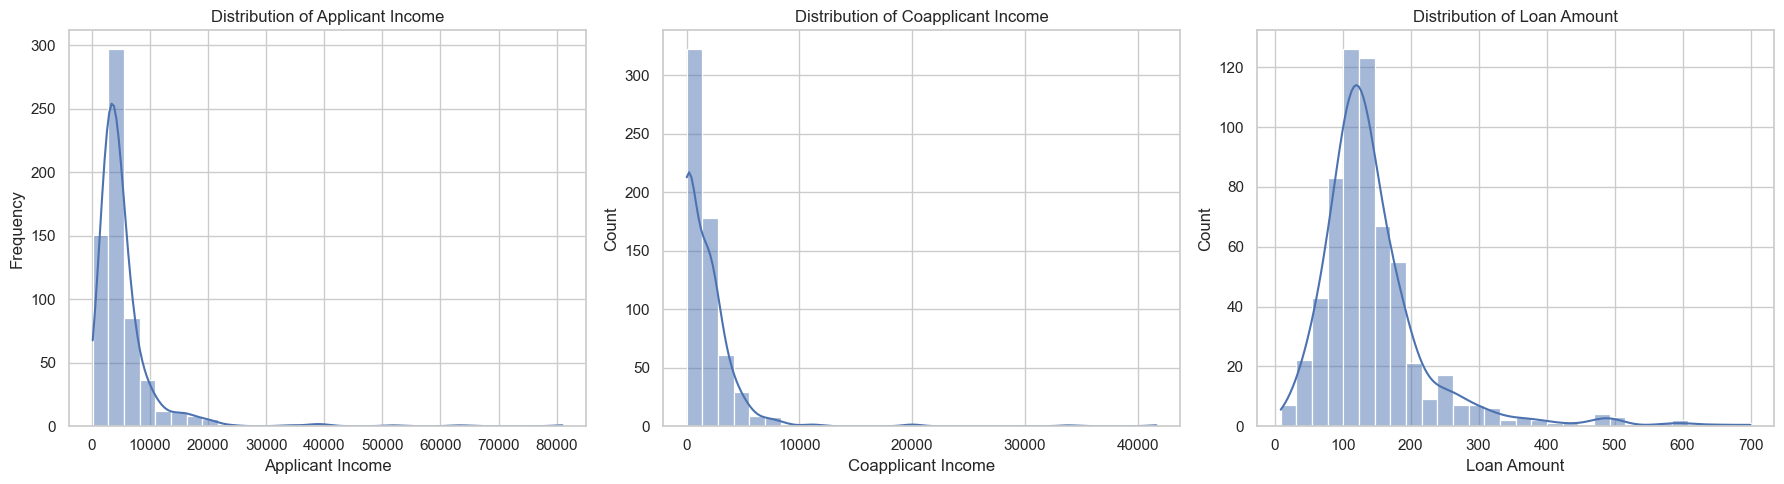

In [12]:
# Setting the aesthetic style for the plots
sns.set(style="whitegrid")

# Creating subplots for histograms
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plotting histograms for ApplicantIncome, CoapplicantIncome, and LoanAmount
sns.histplot(loan_data['ApplicantIncome'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Applicant Income')
ax[0].set_xlabel('Applicant Income')
ax[0].set_ylabel('Frequency')

sns.histplot(loan_data['CoapplicantIncome'], bins=30, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Coapplicant Income')
ax[1].set_xlabel('Coapplicant Income')

sns.histplot(loan_data['LoanAmount'], bins=30, kde=True, ax=ax[2])
ax[2].set_title('Distribution of Loan Amount')
ax[2].set_xlabel('Loan Amount')

plt.tight_layout()
plt.show()

### Correlation Analysis

In [13]:
loan_data = loan_data.drop('Loan_ID', axis=1)

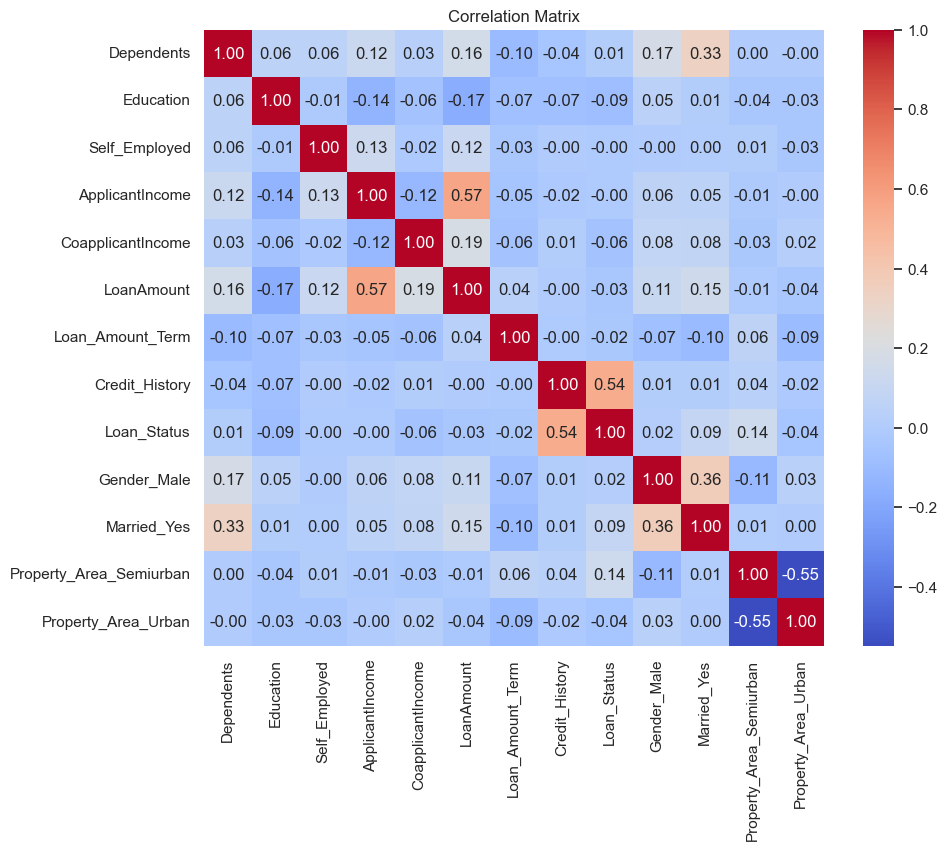

In [14]:
# Calculating the correlation matrix
correlation_matrix = loan_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

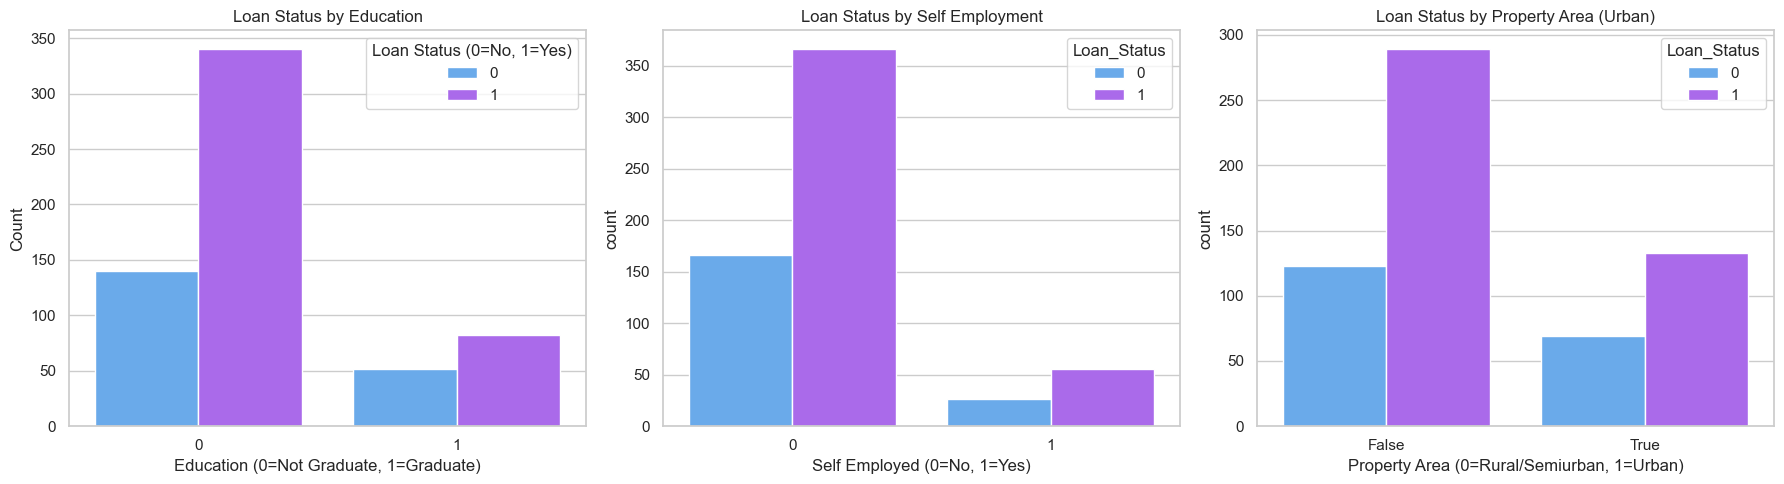

In [15]:
# Setting up for multiple bar plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Education vs Loan status
sns.countplot(x='Education', hue='Loan_Status', data=loan_data, ax=ax[0], palette='cool')
ax[0].set_title('Loan Status by Education')
ax[0].set_xlabel('Education (0=Not Graduate, 1=Graduate)')
ax[0].set_ylabel('Count')
ax[0].legend(title='Loan Status (0=No, 1=Yes)', loc='upper right')

# Self Employed vs Loan status
sns.countplot(x='Self_Employed', hue='Loan_Status', data=loan_data, ax=ax[1], palette='cool')
ax[1].set_title('Loan Status by Self Employment')
ax[1].set_xlabel('Self Employed (0=No, 1=Yes)')

# Property Area vs Loan Status
sns.countplot(x='Property_Area_Urban', hue='Loan_Status', data=loan_data, ax=ax[2], palette='cool')
ax[2].set_title('Loan Status by Property Area (Urban)')
ax[2].set_xlabel('Property Area (0=Rural/Semiurban, 1=Urban)')

plt.tight_layout()
plt.show()


### Feature Engineering

In [16]:
# Features and Target variable
X = loan_data.drop('Loan_Status', axis=1)
y = loan_data['Loan_Status']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shapes of the splits
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((491, 12), (123, 12), (491,), (123,))

In [17]:
print(loan_data.dtypes)
print(loan_data.isnull().any())

Dependents                   int32
Education                    int32
Self_Employed                int32
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int32
Gender_Male                   bool
Married_Yes                   bool
Property_Area_Semiurban       bool
Property_Area_Urban           bool
dtype: object
Dependents                 False
Education                  False
Self_Employed              False
ApplicantIncome            False
CoapplicantIncome          False
LoanAmount                 False
Loan_Amount_Term           False
Credit_History             False
Loan_Status                False
Gender_Male                False
Married_Yes                False
Property_Area_Semiurban    False
Property_Area_Urban        False
dtype: bool


### Logistics Regression Model
Model Selection:

A Logistic Regression model was selected for initial analysis due to its straightforward implementation and effective handling of binary outcomes.
The data was partitioned into an 80% segment for training and a 20% segment for testing.
The chosen model was trained with the training subset and subsequently evaluated on the test set.

In [18]:
X = loan_data.drop('Loan_Status', axis=1)
y = loan_data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Model Evaluation
1. The model’s effectiveness was gauged using accuracy, precision, recall, and the ROC-AUC score.
2. Specific numerical outcomes were not detailed in this session due to execution interruptions.

In [20]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7886178861788617
ROC AUC: 0.7030523255813954


In [21]:
# Checking data types and any remaining NaN values
loan_data.dtypes, loan_data.isnull().any()

(Dependents                   int32
 Education                    int32
 Self_Employed                int32
 ApplicantIncome              int64
 CoapplicantIncome          float64
 LoanAmount                 float64
 Loan_Amount_Term           float64
 Credit_History             float64
 Loan_Status                  int32
 Gender_Male                   bool
 Married_Yes                   bool
 Property_Area_Semiurban       bool
 Property_Area_Urban           bool
 dtype: object,
 Dependents                 False
 Education                  False
 Self_Employed              False
 ApplicantIncome            False
 CoapplicantIncome          False
 LoanAmount                 False
 Loan_Amount_Term           False
 Credit_History             False
 Loan_Status                False
 Gender_Male                False
 Married_Yes                False
 Property_Area_Semiurban    False
 Property_Area_Urban        False
 dtype: bool)

### Recommendations
1. Expanding feature engineering and including interaction effects could potentially increase model accuracy.
2. Implementing rigorous model tuning and optimizing parameters could further refine performance.
3. Regular updates and evaluations of the model against new data sets are recommended to ensure sustained accuracy and relevance.

### Conclusion:
The analysis illuminated several key determinants of loan approval and validated the effectiveness of using logistic regression for such binary classification tasks. Potential future improvements include the adoption of more complex models like Random Forests or Gradient Boosting Machines, which may offer enhanced predictive accuracy.